# Football Pass Clustering

### Step 1: Data Import and Exploration (EDA)

In [1]:
# Imports
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import bz2
import pickle
import time
import itertools
from mplsoccer import Pitch, VerticalPitch

We have a total of ~5000000 pass events available across the following leagues:
- English Premier League (2019/20 - 2022/23)
- English Championship (2019/20 - 2022/23)
- French Ligue 1 (2019/20 - 2022/23)
- Spanish La Liga (2019/20 - 2022/23)
- German Bundesliga (2019/20 - 2022/23)
- Italian Serie A (2019/20 - 2022/23)

These pass_events have been ordered randomly and split into 100 individual data files (approx. 4Mb size each). Previous work in this field suggests that only 4 or 5 features will be needed to cluster these pass events, and ~5000000 records is perhaps overkill for such a problem. For the sake of computational efficiency/speed, 50000 records will be used to initially identify the most appropriate algorithm. Additional records will be bought in to tune and train the clustering algorithm.

1 of the 100 data files containing pass events will be selected at random and used

In [2]:
# Input number of files to load
num_files = 1

# Initialise training dataframe
train_df = pd.DataFrame()

# Generate random integers to load data files
for _ in tqdm(np.arange(0,num_files)):
    data_id = random.randint(0,99)
    train_sample = bz2.BZ2File(f"data/pass_data_{data_id}.pbz2", 'rb')
    train_sample = pickle.load(train_sample)
    train_df = pd.concat([train_df, train_sample])

100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Run some quick checks on data structure, column names, typical values, data types, etc

In [3]:
train_df.shape

(50736, 33)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50736 entries, 761040 to 811775
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 50736 non-null  float64
 1   eventId               50736 non-null  float64
 2   minute                50736 non-null  float64
 3   second                50736 non-null  float64
 4   teamId                50736 non-null  int64  
 5   x                     50736 non-null  float64
 6   y                     50736 non-null  float64
 7   expandedMinute        50736 non-null  float64
 8   period                50736 non-null  int64  
 9   type                  50736 non-null  object 
 10  outcomeType           50736 non-null  object 
 11  qualifiers            50736 non-null  object 
 12  satisfiedEventsTypes  50736 non-null  object 
 13  isTouch               50736 non-null  bool   
 14  playerId              50736 non-null  float64
 15  endX         

There are 33 columns of data available. The objective of this work is to cluster passes based on similar start and end locations, irrespective of the team or player that makes the pass. We can immediately discount the following features and exclude them:
- _index, eventId, teamId, qualifiers, isTouch, playerId, blockedX, blockedY, goalMouthZ, goalMouthY, isShot, relatedEventId, relatedPlayerId, isGoal, cardType, isOwnGoal, match_id, id_ are not relevant fields
- _type, eventType_ are always set to 'Pass'
- _outcomeType_ is always set to 'Successful'
- _minute, second, expandedMinute, period & cumulative_mins_ all represent time in the game, which is independent of pass properties
- _satisfiedEventsTypes_ contains information on pass height, but this strongly correlates with pass distance and has been omitted

The following features are going to be useful:
- _x_ gives start location of pass (along pitch length)
- _y_ gives start location of pass (along pitch width)
- _endX_ gives end location of pass (along pitch length)
- _endY_ gives end location of pass (along pitch width)

These are all continous features, that we formally define below:

In [5]:
continous_features = ['x', 'y', 'endX', 'endY']

Check whether we have any missing data within the chosen features:

In [6]:
train_df[continous_features].isna().sum()

x       0
y       0
endX    0
endY    0
dtype: int64

Finally, we must make a decision on whether we want to generate additional features that might benefit the clustering algorithm. Significant thought was put into whether calculating **pass angle** and **pass distance** would be useful, rather than using end location [x,y].

Clustering with an angular feature poses it's own problems. A standard clustering algorithm does not know that 0.01deg and 359.99deg are almost the same angle. To avoid this problem the following solutions are feasible:
- Represent angle as two features cos(theta) and sin(theta)
- Map angle onto a unit circle and represent as [x,y] co-ordinates.

Both of these solutions involve the introduction of two features to represent angle. In fact, mapping angle onto a unit circle is somewhat similar to using the original endX and endY features.

Another potential solution would be to encode both start location and end location using a grid that seperates the [x,y] co-ordinate space into regions with their own ID. These regions/IDs would then require one-hot encoding to identify where the pass started and ended without making assumptions about the relationship between regions. This would largely expand the feature space, and would likely not cluster passes in adjacent blocks together.

Based on these consideration, the original endX and endY features are chosen to train the model.

### Step 2: Pre-process Data

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

The [x,y] locations are provided in units [% pitch length, % pitch width] respectively. We first construct a custom transformer to convert features to yards.

In [8]:
# Transformer to convert locations to yards
class convertYards(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['x'] = X['x'] * (120/100)
        X['y'] = X['y'] * (80/100)
        X['endX'] = X['endX'] * (120/100)
        X['endY'] = X['endY'] * (80/100)
        return X

We then scale the features using a custom scaler. We know that the dimensions of a football pitch is approximately 120yd x 80yd, and we therefore choose to scale by dividing through by 120 yards. This preserves the relative euclidean distances of the points.

In [9]:
# Transformer to scale locations
class customScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.max_x = 120
        self.max_y = 80
        return self
    def transform(self, X, y=None):
        X['x'] = X['x'] / 120
        X['y'] = X['y'] / 120
        X['endX'] = X['endX'] / 120
        X['endY'] = X['endY'] / 120
        return X
    
# Combine transformers into a feature pre-processing pipeline, which also drops non-required columns
feature_transformer = Pipeline(steps = [('convert_yards', convertYards()),
                                        ('custom_scale', customScaler())])

feature_preprocessor = ColumnTransformer(transformers = [('transformer', feature_transformer, continous_features)],
                                remainder = 'drop')

Finally we add these pre-processing steps to our machine learning pipeline

In [10]:
clusterModel = Pipeline(steps = [('preprocessor', feature_preprocessor)])

Check pre-processing steps work as expected

In [11]:
train_df_pp = clusterModel.fit_transform(train_df)
train_df_pp = pd.DataFrame(train_df_pp, columns = continous_features)
train_df_pp.head(5)

x         y   endX      endY
0  0.640  0.202667  0.639  0.236000
1  0.321  0.218667  0.317  0.414000
2  0.722  0.153333  0.719  0.016667
3  0.620  0.644000  0.733  0.560000
4  0.701  0.159333  0.704  0.035333

### Step 3 - Model Selection

In [12]:
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation, BisectingKMeans, DBSCAN, OPTICS, Birch, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import make_scorer, davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

The scikit learn cross_validation function that we would typically use does not support unsupervised machine learing. It expects a "y_true" parameter to assess the performance of clustering algorithms. Given that this is unavailable, we will code our own method to compare model performance. The following algorithms will be explored:
* k Means
* Bisecting k Means
* Mean Shift
* DBScan
* OPTICS
* Birch
* Gaussian Mixture

Before instantiating these models, initial hyperparameter selections require further thought.

#### k Means, Bisecting k Means and Gaussian Mixture

Previous work in this field, most notably research undertaken by [Statsbomb](https://statsbomb.com/articles/soccer/statsbomb-360-exploring-line-breaking-passes/), uses 60 pass clusters to undertake analysis of football matches. Therefore we will instantiate the k Means and bisecting k Means models with _n_clusters = 60_. We also aim to have the other clustering algorithms group passes into approximately 60 clusters.

#### Mean Shift
To choose an appropriate bandwidth for mean shift, we can use the scikit learn built-in estimate_bandwith function. It is passed with a quantile parameter that dictates the which of the ordered pairwise distances are selected for bandwidth.

In [13]:
estimate_bandwidth(train_df_pp.to_numpy(), quantile=0.3, n_jobs=-1)

0.40774755837783255

In [14]:
estimate_bandwidth(train_df_pp.to_numpy(), quantile=0.5, n_jobs=-1)

0.5275780312728523

We will initially try bandwidths of 0.41 and 0.53

#### DBSCAN and OPTICS
DBSCAN requires definition of _epsilon_ and _min_samples_. For larger datasets, with lots of noise, it suggested to go with _min_samples_ equal to twice the number of dimensions. However in this case we want to ensure that each cluster contains an appropriate volume of passes, and we therefore select a much higher value of _min_samples_ of 0.1% the size of the training set. We can then choose an appropriate epsilon by plotting a k-distance graph. To do so we order the distances of each point to its nearest _k = min_samples-1_ neighbours. Appropriate value(s) of epsilon are indicated where the resulting line shows an "elbow" and starts to rapidly change slope

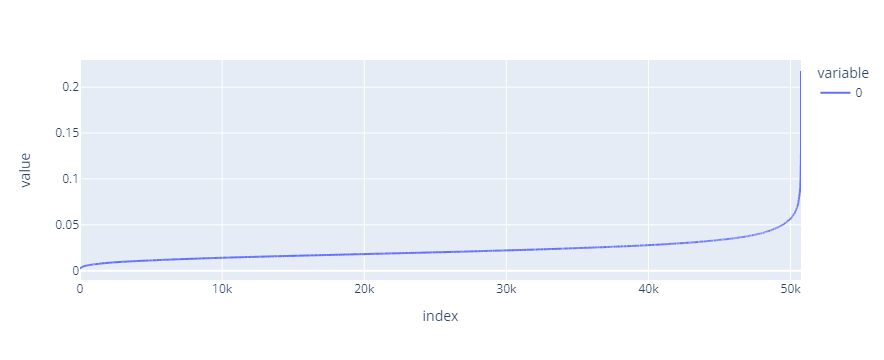

In [15]:
# Set number of samples required per cluster (0.1% dataset)
min_samples = 50

# Fit kNN to data and plot ordered distances
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(train_df_pp.to_numpy())
distances, indices = neighbors_fit.kneighbors(train_df_pp.to_numpy())
distances = np.sort(distances, axis=0)
distances = distances[:,1]
px.line(distances)

We will instantiate a DBSCAN algorithm, with _min_samples = 50_ and _eps ~= 0.046_. When instantiating the OPTICS algorithm, we will choose _max_eps = 0.06_ to cover the entirety of the elbow.

#### Birch

Birch requires definition of _threshold_, which effectively limits the size of sub-clusters generated, and _branching_factor_ which limits the number of subclusters in each node. The _threshold_ is lowered from its default value of 0.5 to 0.1-0.2 to avoid large clusters, and generate more clusters at higher density. _branching_factor_ and _threshold_ are then quickly tuned in combination to produce an appropriate number of clusters. Finally, number of clusters is limited to 60 by passing _n_clusters = 60_. 

#### Multi-model Evaluation

In [23]:
models = [('k_means', KMeans(n_clusters=60, n_init=10)),
          ('bisecting_k_means', BisectingKMeans(n_clusters=60, n_init=10)),
          ('dbscan_m20', DBSCAN(n_jobs=-1, eps=0.033, min_samples=20)),
          ('dbscan_m50', DBSCAN(n_jobs=-1, eps=0.04585, min_samples=50)),
          ('optics_m50', OPTICS(n_jobs=-1, max_eps=0.06, min_samples=50)),
          ('birch_t015', Birch(n_clusters=60, branching_factor=75,threshold=0.15)),
          ('gm', GaussianMixture(n_components=60, n_init=10)),
          ]

Define a list of metrics to evaluate the machine learning models against:

* Fit and Predict time: Time taken to fit model and predict on training data
* Number of clusters: Aiming for approx. 60
* Silhouette score: Mean similarity of points to own cluster [-1, 1] (high is favourable)
* Davies Bouldin score: Similarity of each cluster to its nearest cluster (low is favourable)
* Calinski Harabasz score: Ratio of sum of between-cluster dispersion and within-cluster dispersion (high is favourable)
* Visual inspection: Visual interrogation of clusters

Fitting k_means
Fitting bisecting_k_means
Fitting dbscan_m20
Fitting dbscan_m50
Fitting optics_m50
Fitting birch_t015
Fitting gm


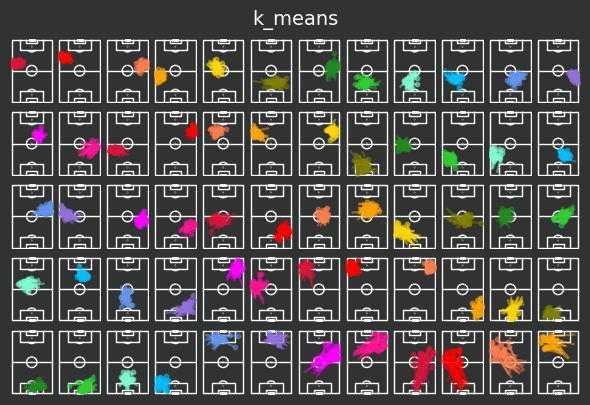

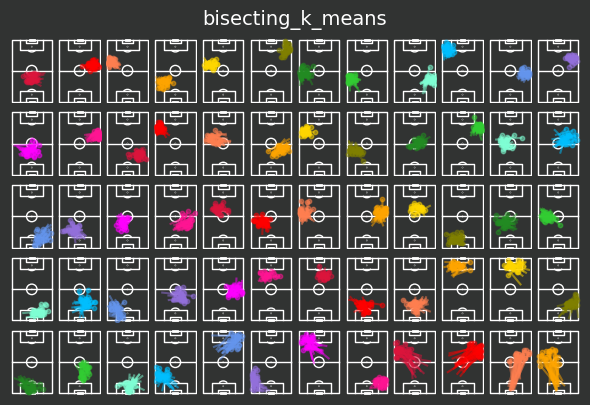

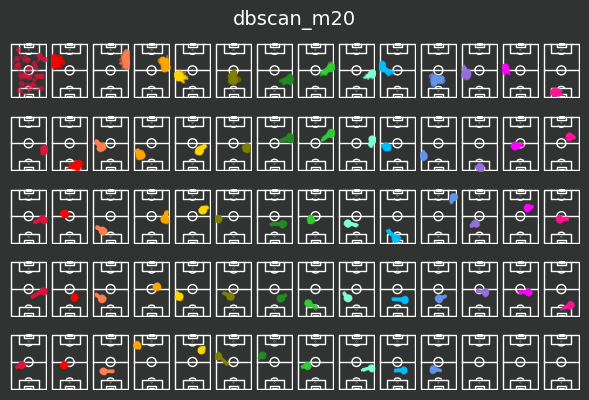

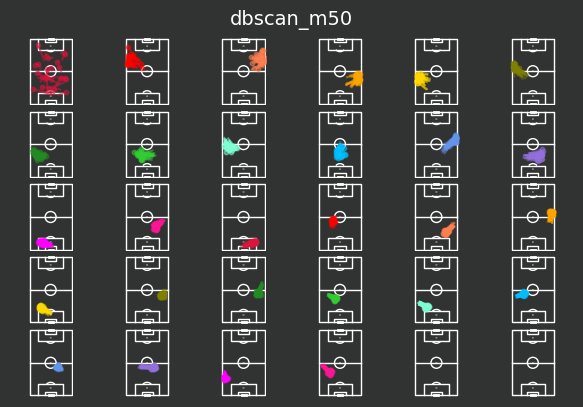

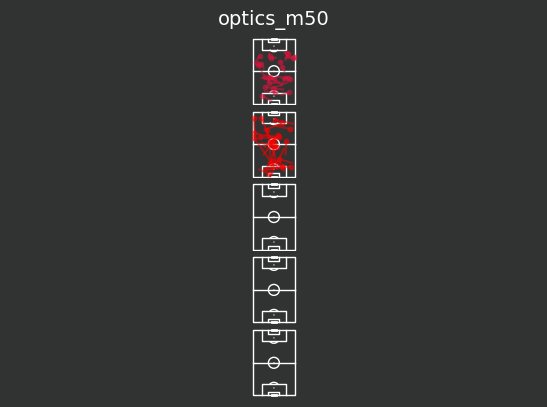

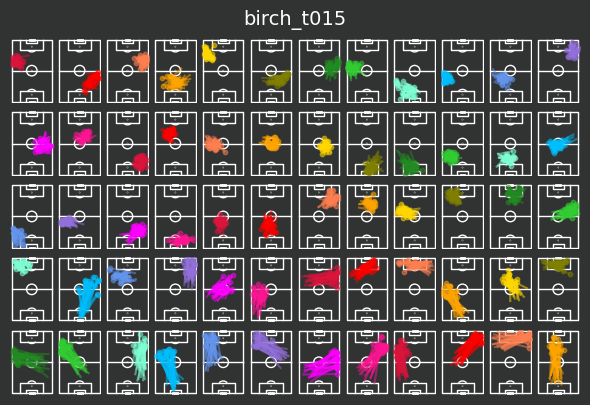

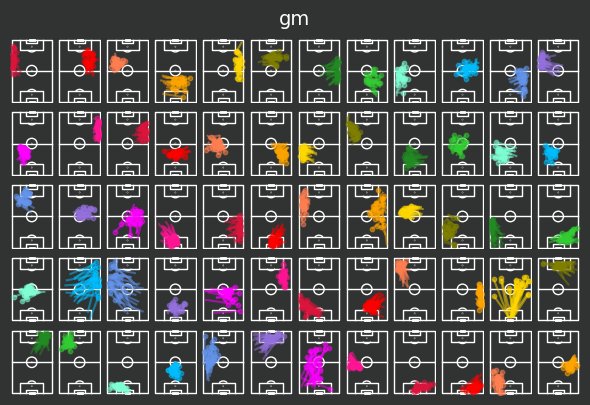

In [24]:
# Model performance dataframe
model_performance = pd.DataFrame()
    
# Colouring to apply to clusters
cluster_colour_list = 100*['crimson', 'red', 'coral', 'orange', 'gold', 'olive', 'forestgreen', 'limegreen', 'aquamarine', 'deepskyblue', 'cornflowerblue', 'mediumpurple', 'magenta', 'deeppink']

# Iterate through each model and train
for name, model in models:
    print(f"Fitting {name}")
    
    # Construct test pipeline
    test_pipeline = Pipeline(steps = [('preprocessor', feature_preprocessor),
                                      ('model', model)])
    
    # Fit model and make predictions, returning cluster labels
    start_t = time.time()
    labels = test_pipeline.fit_predict(train_df)
    end_t = time.time()

    # Calculate performance metrics and save to dataframe (note that these require pre-processed numpy arrays as input)
    fit_pred_time = end_t - start_t
    n_clusters = len(set(labels))
    s_score = silhouette_score(train_df_pp.to_numpy(), labels)
    db_score = davies_bouldin_score(train_df_pp.to_numpy(), labels)
    ch_score = calinski_harabasz_score(train_df_pp.to_numpy(), labels)
    model_performance = pd.concat([model_performance, pd.DataFrame([name, fit_pred_time, n_clusters, s_score, db_score, ch_score]).T], axis=0)
    
    # Assign labels to data
    train_df['cluster_id'] = labels
    nrows = 5
    ncols = int(np.ceil(len(train_df['cluster_id'].unique())/nrows))
    
    # Set up mplsoccer pitch grid object
    pitch = VerticalPitch(pitch_color='#313332', pitch_type='opta', line_color='w', linewidth=1)
    fig, ax = pitch.grid(nrows = nrows, ncols=ncols, title_height=0.05, endnote_height=0, axis=False, grid_height=0.9)
    fig.set_size_inches(6, 4)
    fig.set_facecolor('#313332')
    ax['pitch'] = ax['pitch'].reshape(-1)
    ax['title'].text(0.5, 0.65, f"{name}", fontsize=14, va='center', ha='center', color = 'w')
    
    # Iterate through each cluster, from most to least common
    for idx, cluster_id in enumerate(train_df.groupby(['cluster_id'])['cluster_id'].count().sort_values(ascending=False).index.tolist()):
        
        # Get all passes in cluster, and select the top 25 to visualise
        cluster_passes = train_df[train_df['cluster_id'] == cluster_id]
        cluster_passes = cluster_passes.head(min(len(cluster_passes), 25))
        
        # Draw cluster passes
        pitch.lines(cluster_passes['x'], cluster_passes['y'], cluster_passes['endX'], cluster_passes['endY'],
                    lw=1.5, comet=False, color = cluster_colour_list[idx], alpha = 0.5, ax=ax['pitch'][idx])
        pitch.scatter(cluster_passes['endX'], cluster_passes['endY'], s=10, color = cluster_colour_list[idx], alpha = 0.5, ax=ax['pitch'][idx])
    
    # Title on figure
    plt.savefig(f"images/{name}.png")

Summarise model performance:

In [25]:
model_performance.columns = ['Name','Fit/Pred Time','Num Clusters','S Score','DB Score', 'CH Score']
model_performance.sort_values('S Score', ascending = False).reset_index(drop=True)

Name Fit/Pred Time Num Clusters   S Score   DB Score  \
0            k_means      4.279058           60   0.20474   1.171276   
1         birch_t015      0.867918           60  0.183251   1.231672   
2  bisecting_k_means     23.432373           60  0.146141   1.499479   
3         optics_m50     94.133631            2  0.079633  11.374757   
4                 gm    167.867193           60  0.031023   1.770076   
5         dbscan_m50      0.602318           28 -0.398903   1.523258   
6         dbscan_m20      0.486232           67 -0.600878   1.470107   

       CH Score  
0  10156.012777  
1   8282.764332  
2   8768.653338  
3    268.682694  
4   4973.284773  
5     607.75163  
6    153.338622

It is clear that the k Means algorithm outperforms other clustering algorithms when it comes to locational clustering of football passes. We must be careful when making such statements purely on the metrics listed above, as they are inhrently biased towards particular clustering methods (such as K Means).

MeanShift was excluded due to run-time, with time-complexity proportional to the square of the number of data-points. The DBSCAN and OPTICS algorithms are more appropriate for looking at irregular structure and high-density clusters within the data (and therefore are effective at identifying outliers). Football passes tend to be somewhat evenly distributed over the pitch (low density) and these algorithms become less appropriate. We can clearly observe the tighter/more dense clusters and the single cluster of perceived noise. The OPTICS algorithm actually aims to select an optimal value of _epsilon_ for us, and we can see that it chooses _epsilon_ that generates just two clusters. This again demonstrates that the algorithm is finding difficulty in clustering the low density data.

A combination of favourable metric scores, interpretable and somewhat symmetric clusters, and acceptable run time means that the K Means algorithm will be chosen to progress. We add it to our pipeline:

In [28]:
clusterModel.steps.append(('model',KMeans()))

### Step 4 - Hyperparameter Tuning

Now we look to optimise the KMeans algorithm through tuning hyper-parameters. We are going to apply a simple grid search approach to tune parameters. However, given that we do not have access to "y_true", we are unable to make use of sklearn's GridSearchCV class. We must instead construct our own hyper-parameter tuning methodology.

Despite previous work using 60 clusters to group football passes, we will now experiment with slightly different values. The following parameters will be tuned:
- algorithm: implementation of K Means. lloyd and elkan algorithms are available
- n_clusters: number of clusters.
- tol: tolerance to declare convergence
- n_init: number of times run with different centroid seeds

In [33]:
param_grid = {'model__algorithm': ['lloyd', 'elkan'],
              'model__n_clusters': [55, 60, 65, 70],
              'model__tol': [1e-4, 1e-5, 1e-6],
              'model__n_init': [5, 10, 20],
              'model__init': ['k-means++'],
              'model__max_iter':[1000]
             }

Loop through hyper-parameter grid and store model performance on each loop:

In [34]:
# Model performance dataframe
tuned_model_performance = pd.DataFrame()

# Build parameter combinations
params, param_values = zip(*param_grid.items())
model_permutation_dict = [dict(zip(params, v)) for v in itertools.product(*param_values)]

# Iterate through permutations
for model_instance in tqdm(model_permutation_dict):
    
    # Set model hyperparameters
    for param, param_value in model_instance.items():
        setattr(clusterModel['model'], param.replace('model__',''), param_value)
    
    # Fit model and make predictions
    start_t = time.time()
    labels = clusterModel.fit_predict(train_df)
    end_t = time.time()
    
    # Calculate performance metrics and save to dataframe
    fit_pred_time = end_t - start_t
    n_clusters = len(set(labels))
    s_score = silhouette_score(train_df_pp.to_numpy(), labels)
    db_score = davies_bouldin_score(train_df_pp.to_numpy(), labels)
    ch_score = calinski_harabasz_score(train_df_pp.to_numpy(), labels)
    tuned_model_performance = pd.concat([tuned_model_performance, pd.DataFrame([str(model_instance), fit_pred_time, n_clusters, s_score, db_score, ch_score]).T], axis=0)

100%|██████████| 72/72 [58:45<00:00, 48.96s/it]


Visualise results

In [39]:
tuned_model_performance.columns = ['Parameters','Fit/Pred Time','Num Clusters','S Score','DB Score','CH Score']
tuned_model_performance = tuned_model_performance.sort_values('S Score', ascending = False).reset_index(drop=True)
tuned_model_performance

Parameters Fit/Pred Time  \
0   {'model__algorithm': 'elkan', 'model__n_cluste...     93.434117   
1   {'model__algorithm': 'elkan', 'model__n_cluste...     31.135925   
2   {'model__algorithm': 'lloyd', 'model__n_cluste...      8.364386   
3   {'model__algorithm': 'lloyd', 'model__n_cluste...     13.136952   
4   {'model__algorithm': 'elkan', 'model__n_cluste...     73.250194   
..                                                ...           ...   
67  {'model__algorithm': 'elkan', 'model__n_cluste...     19.502741   
68  {'model__algorithm': 'elkan', 'model__n_cluste...     16.612373   
69  {'model__algorithm': 'lloyd', 'model__n_cluste...     13.451267   
70  {'model__algorithm': 'lloyd', 'model__n_cluste...      3.508286   
71  {'model__algorithm': 'lloyd', 'model__n_cluste...      1.700033   

   Num Clusters   S Score  DB Score      CH Score  
0            70  0.208629  1.154755   9547.066168  
1            65  0.208308  1.156184   9844.527737  
2            70  0.208131   1.15536   9580.254912  
3            65  0.208123  1.160967   9852.316471  
4            70  0.208102  1.159994   9546.107453  
..          ...       ...       ...           ...  
67           60  0.203918  1.176945  10157.177784  
68           55   0.20377  1.190202  10507.697944  
69           55  0.203311  1.187564  10526.075603  
70           70  0.203023  1.190133   9503.039114  
71           55  0.202911  1.178427  10534.820524  

[72 rows x 6 columns]

In [43]:
tuned_model_performance['Parameters'].head(5).values

array(["{'model__algorithm': 'elkan', 'model__n_clusters': 70, 'model__tol': 1e-05, 'model__n_init': 20, 'model__init': 'k-means++', 'model__max_iter': 1000}",
       "{'model__algorithm': 'elkan', 'model__n_clusters': 65, 'model__tol': 0.0001, 'model__n_init': 10, 'model__init': 'k-means++', 'model__max_iter': 1000}",
       "{'model__algorithm': 'lloyd', 'model__n_clusters': 70, 'model__tol': 1e-05, 'model__n_init': 10, 'model__init': 'k-means++', 'model__max_iter': 1000}",
       "{'model__algorithm': 'lloyd', 'model__n_clusters': 65, 'model__tol': 0.0001, 'model__n_init': 20, 'model__init': 'k-means++', 'model__max_iter': 1000}",
       "{'model__algorithm': 'elkan', 'model__n_clusters': 70, 'model__tol': 0.0001, 'model__n_init': 20, 'model__init': 'k-means++', 'model__max_iter': 1000}"],
      dtype=object)

The performance difference between models is not significant. It is clear that 65 and 70-cluster models are performing better clustering than 55 and 60-cluster models. Tolerance and number of initialisations do not appear to impact the models performance. We have selected the following parameters for the K-means model:
- Algorithm: Elkan
- Number of clusters: 65
- Tolerance: 1e-4
- Num. initialisations: 10
- Initialisation method: k-means++
- Max iterations: 1000

In [44]:
chosen_params = {'model__algorithm': 'elkan',
              'model__n_clusters': 65,
              'model__tol': 1e-4,
              'model__n_init': 10,
              'model__init': 'k-means++',
              'model__max_iter': 1000
             }

for param, param_value in chosen_params.items():
        setattr(clusterModel['model'], param.replace('model__',''), param_value)

Display final machine learning pipeline

In [45]:
clusterModel

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('transformer',
                                                  Pipeline(steps=[('convert_yards',
                                                                   convertYards()),
                                                                  ('custom_scale',
                                                                   customScaler())]),
                                                  ['x', 'y', 'endX',
                                                   'endY'])])),
                ('model',
                 KMeans(algorithm='elkan', max_iter=1000, n_clusters=65,
                        n_init=10))])

### Step 5 - Training and Evaluation

Train the model based on the chosen algorithm and hyperparameters. Here we will bring in all of the training data, recognising that this will take a very long time to train.

In [51]:
# Input number of files to load
num_files = 100

# Initialise training dataframe
fin_train_df = pd.DataFrame()

# Generate random integers to load data files
for _ in tqdm(np.arange(0,num_files)):
    data_id = random.randint(0,99)
    train_sample = bz2.BZ2File(f"data/pass_data_{data_id}.pbz2", 'rb')
    train_sample = pickle.load(train_sample)
    fin_train_df = pd.concat([fin_train_df, train_sample])

fin_train_df.shape

100%|██████████| 100/100 [28:10<00:00, 16.90s/it]


(5073600, 33)

Final training

In [52]:
# Fit model and time
start_t = time.time()
clusterModel.fit(fin_train_df)
end_t = time.time()

# Print train time
print(f"Fit time: {round((end_t - start_t)/60,2)} mins")

Fit time: 46.93 mins


### Step 6 - Prediction

In [53]:
from joblib import dump, load

Use model to cluster the initial sample of 50000 passes, and visualise:

Predict time: 0.0 mins


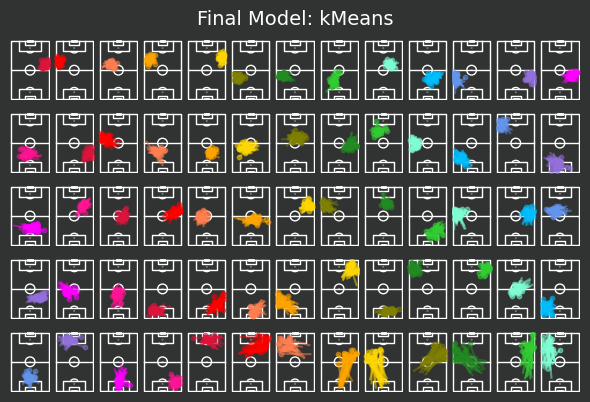

In [54]:
# Make predictions and time
start_t = time.time()
labels = clusterModel.predict(train_df)
end_t = time.time()

# Print prediction time
print(f"Predict time: {round((end_t - start_t)/60,2)} mins")

# Assign cluster labels to data
train_df['cluster_id'] = labels
nrows = 5
ncols = int(np.ceil(len(train_df['cluster_id'].unique())/nrows))

# Set up mplsoccer pitch grid object
pitch = VerticalPitch(pitch_color='#313332', pitch_type='opta', line_color='w', linewidth=1)
fig, ax = pitch.grid(nrows = nrows, ncols=ncols, title_height=0.05, endnote_height=0, axis=False, grid_height=0.9)
fig.set_size_inches(6, 4)
fig.set_facecolor('#313332')
ax['pitch'] = ax['pitch'].reshape(-1)
ax['title'].text(0.5, 0.65, "Final Model: kMeans", fontsize=14, va='center', ha='center', color = 'w')

# Iterate through each cluster, from most to least common
for idx, cluster_id in enumerate(train_df.groupby(['cluster_id'])['cluster_id'].count().sort_values(ascending=False).index.tolist()):

    # Get all passes in cluster, and select the top 25 to visualise
    cluster_passes = train_df[train_df['cluster_id'] == cluster_id]
    cluster_passes = cluster_passes.head(min(len(cluster_passes), 25))

    # Draw cluster passes
    pitch.lines(cluster_passes['x'], cluster_passes['y'], cluster_passes['endX'], cluster_passes['endY'],
                lw=1.5, comet=False, color = cluster_colour_list[idx], alpha = 0.5, ax=ax['pitch'][idx])
    pitch.scatter(cluster_passes['endX'], cluster_passes['endY'], s=10, color = cluster_colour_list[idx], alpha = 0.5, ax=ax['pitch'][idx])

# Title on figure
plt.savefig("images/final_model_predictions.png")

The model is saved as a .joblib file. The model will be wrapped in a python function such that will also remove non-pass events and capture/handle any errors. The function will be documented for easy use within any football analytics work-flow.

In [55]:
dump(clusterModel, 'output/PassClusterModel65.joblib') 

['output/PassClusterModel65.joblib']